In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

import pandas as pd
import load_data
import LFP
from joblib import Parallel, delayed
import h5py

from scipy.signal import find_peaks
import pickle

C:\Users\ML_4\anaconda3\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# bandpass filter

dates = ['031723','032023','032823','033123','040423','040723']
band = [80,180]

for date in dates:
    
    timestamps, lfpData = load_data.load_LFP(date)
    lfpData = np.asarray(lfpData)
    n_channels = lfpData.shape[1]

    def process_channel(ch):
        sig = lfpData[:, ch]
        preprocessed = LFP.preprocess_LFP(sig)  
        band_sig, power, _ = LFP.freq_band(preprocessed, band)
        return  band_sig, power # returns (band_sig, power, zscored, peaks)

    # Parallel over channels
    with tqdm_joblib(tqdm(total=n_channels)) as progress_bar:
        results = Parallel(n_jobs=-1)(delayed(process_channel)(ch) for ch in range(n_channels))

    # Unpack results into arrays
    band_sig = np.column_stack([r[0] for r in results])
    power = np.column_stack([r[1] for r in results])

    # Save as HDF5
    outpath = f"D:/SWR/Session_{date}_RippleBand_{band[0]}_{band[1]}.h5"

    with h5py.File(outpath, "w") as h5:
        h5.create_dataset("band_sig", data=band_sig, dtype='float32')
        h5.create_dataset("power", data=power, dtype='float32')
        h5.create_dataset("timestamps", data=timestamps, dtype='float32')

    print(f"Saved {outpath}")

In [2]:
class RippleDataset2:
    
    def __init__(self, h5_path):
        self.f = h5py.File(h5_path, 'r')
        self.timestamps = self.f['timestamps']
        self.band_sig = self.f['band_sig']
        self.power = self.f['power']
        self.power_z = self.f['power_z']

    def get_trace(self, time):
        return {
            'band_sig': self.band_sig[time, :],
            'power': self.power[time, :],
            'power_z': self.power_z[time,:]
        }

    def get_band_sig(self, time, channel):
        return self.band_sig[time, :][:,channel]

    def get_power(self, time, channel):
        return self.power[time, :][:,channel]

    def get_power_z(self,time, channel):
        return self.power_z[time,:][:,channel]

    def close(self):
        self.f.close()


In [3]:
class RippleDataset:
    
    def __init__(self, h5_path):
        self.f = h5py.File(h5_path, 'r')
        self.band_sig = self.f['band_sig']
        self.power = self.f['power']
        self.zscored = self.f['zscored']
        self.peaks = self.f['peaks']

    def get_trace(self, time):
        return {
            'band_sig': self.band_sig[time, :],
            'power': self.power[time, :],
            'zscored': self.zscored[time, :],
        }

    def get_band_sig(self, time):
        if len(time)==0:
            return self.band_sig[:]
        else:
            return self.band_sig[time, :]

    def get_power(self, time):
        if len(time)==0:
            return self.power[:]
        else:
            return self.power[time, :]

    def get_zscored(self, time):
        if len(time)==0:
            return self.zscored[:]
        else:
            return self.zscored[time, :]
    
    def get_peaks(self):
        peaks_grp = self.peaks
        names = sorted(peaks_grp.keys(), key=lambda x: int(x[2:]))
        all_peaks = []
        for ch in names:
            all_peaks.append(peaks_grp[ch][:]) 
        return all_peaks

    def close(self):
        self.f.close()


In [4]:
def get_ripple_band(time_idx):

    idx = np.arange(time_idx-500,time_idx+500)
    raw_LFP = lfpData[idx,:].astype(np.float32)

    ds = RippleDataset2("D:/SWR/Session_%s_RippleBand_80_180.h5" % date)
    band80_180 = ds.get_trace(idx)
    ds.close()
    
    ds = RippleDataset2("D:/SWR/Session_%s_RippleBand_150_250.h5" % date)
    band150_250 = ds.get_trace(idx)
    ds.close()
    
    ds = RippleDataset2("D:/SWR/Session_%s_RippleBand_80_250.h5" % date)
    band80_250 = ds.get_trace(idx)
    ds.close()

    return raw_LFP, band80_180, band150_250, band80_250

In [109]:
def identify_ripple(date,zscore_th=15):
    
    ds = RippleDataset("D:/SWR/Session_%s_ripples_80_180.h5" % date)
    SWR_peaks = ds.get_peaks()
    ds.close()
    
    timestamps, lfpData = load_data.load_LFP(date)
    ds2 = RippleDataset2("D:/SWR/Session_%s_RippleBand_80_180.h5" % date)
    
    nchannels = lfpData.shape[1]
    ripple_peak = np.zeros(lfpData.shape)
    ripple_dur = np.zeros(lfpData.shape)
    
    for ii in range(nchannels):
        
        if len(SWR_peaks[ii])>0:
            
            ripple_peak[SWR_peaks[ii][:,0].astype(int),ii]=1
            
            for row in SWR_peaks[ii]:
                
                start = int(row[1])
                end   = int(row[2])
                ripple_dur[start:end, ii] = 1    # mark the entire duration from ripple on to ripple off as 1
    
    channels_detected = ripple_dur.sum(axis=1)
    
    # get ripple dataframe, label each ripple with number of channels detected 
    
    ripple_exist = 1*(channels_detected>0)
    ripple_starts = np.where(np.diff(ripple_exist)==1)[0]
    ripple_stops = np.where(np.diff(ripple_exist)==-1)[0]
    
    detected_channels = np.zeros((len(ripple_starts),6))
    outlier_channels = np.zeros((len(ripple_starts),6))
    
    for ii in range(len(ripple_starts)):
    
        chunk = ripple_dur[ripple_starts[ii]:ripple_stops[ii],:]
        
        for p in range(int(nchannels/32)):
        
            p_channels = np.arange(32*p,32*p+32)
            detected_channels[ii,p] = chunk[:,p_channels].sum(axis=1).max()
            band_chunk = ds2.get_power_z(np.arange(ripple_starts[ii],ripple_stops[ii]),p_channels)
            outlier_channels[ii,p] = np.sum(np.sum(band_chunk>zscore_th,axis=0)>0)
    
    ripple_channel = pd.DataFrame(data={
        'rippleID': np.arange(len(ripple_starts)),
        'on': ripple_starts,
        'off': ripple_stops,
        'dur': ripple_stops - ripple_starts,
        'ofc_channels':detected_channels[:,:3].sum(axis=1),
        'hpc_channels':detected_channels[:,3:].sum(axis=1),
        'detected_channels': list(detected_channels),
        'outlier_channels': list(outlier_channels),
        'ofc_outlier': np.sum(outlier_channels[:,:3]>16,axis=1)==3,
        'hpc_outlier': np.sum(outlier_channels[:,3:]>16,axis=1)==p-3
    })

    return ripple_channel

In [90]:
date = '032023'
ripple_channel = identify_ripple(date)

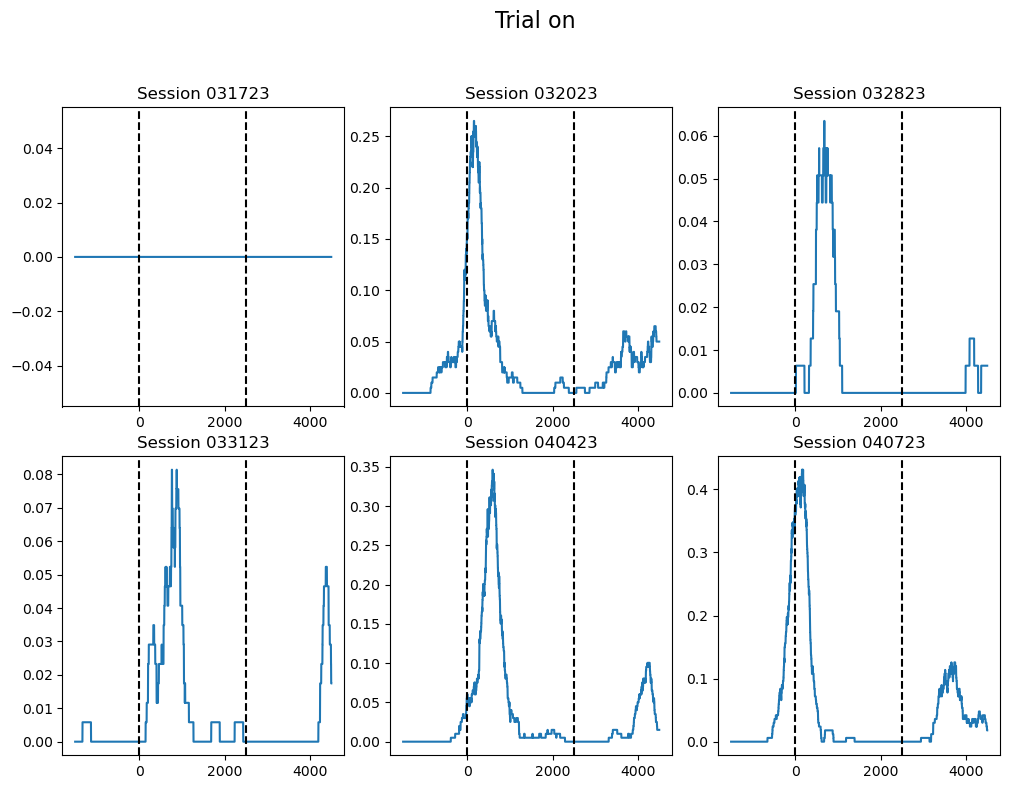

In [110]:
window = [-1500,4500]
timestamps = np.arange(window[0],window[1])

plt.close('all')
fig, axes = plt.subplots(2,3,figsize=(12,8))

for jj, date in enumerate(['031723','032023','032823','033123','040423','040723']):

    ripple_channel = identify_ripple(date)

    nwbfile = load_data.load_nwbfile('Bart',date) 
    trial_df = nwbfile.intervals['trials'].to_dataframe()
    trial_df = trial_df.loc[:,trial_df.columns[:-1]]
    
    row, col = np.divmod(jj,3)
    ax = axes[row,col]
    
    peaks = ripple_channel.query('ofc_outlier & (hpc_channels==0)').on.values
    _, ripple_rate_noOFC = get_ripple_raster(peaks,trial_df.query('trialerror<2'),window,istrial=1)
    ax.plot(timestamps,ripple_rate_noOFC)
    
    # peaks = ripple_channel.query('(OFC_channels==0) & (HPC_channels>0)').on.values
    # ripple_rate_noOFC = get_ripple_raster(peaks,trial_df.query('trialerror==0'),window,istrial=0)
    # ax.plot(timestamps,ripple_rate_noOFC,label='Navigation',color='darkviolet')
    
    # peaks = ripple_channel.query('(OFC_channels>0) & (HPC_channels>0)').on.values
    # ripple_rate_OFC = get_ripple_raster(peaks,trial_df.query('trialerror<2'),window,istrial=0)
    # ax.plot(timestamps,ripple_rate_OFC,label='OFC detected')
    
    ax.set_title(f"Session {date}")
    ax.axvline(0,color='k',ls='--')
    ax.axvline(2500,color='k',ls='--')
    
    # plt.legend()
    plt.tight_layout(h_pad=0.4,w_pad=0.4,rect=[0.05,0,0.9,0.95])
    plt.suptitle('Trial on',fontsize=16)
    plt.savefig(f"D:/SWR/Ripple rate, OFC outlier, trial on")

C:\Users\ML_4\AppData\Local\Temp\ipykernel_8304\3955088648.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\ML_4\AppData\Local\Temp\ipykernel_8304\3955088648.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\ML_4\AppData\Local\Temp\ipykernel_8304\3955088648.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\ML_4\AppData\Local\Temp\ipykernel_8304\3955088648.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legen

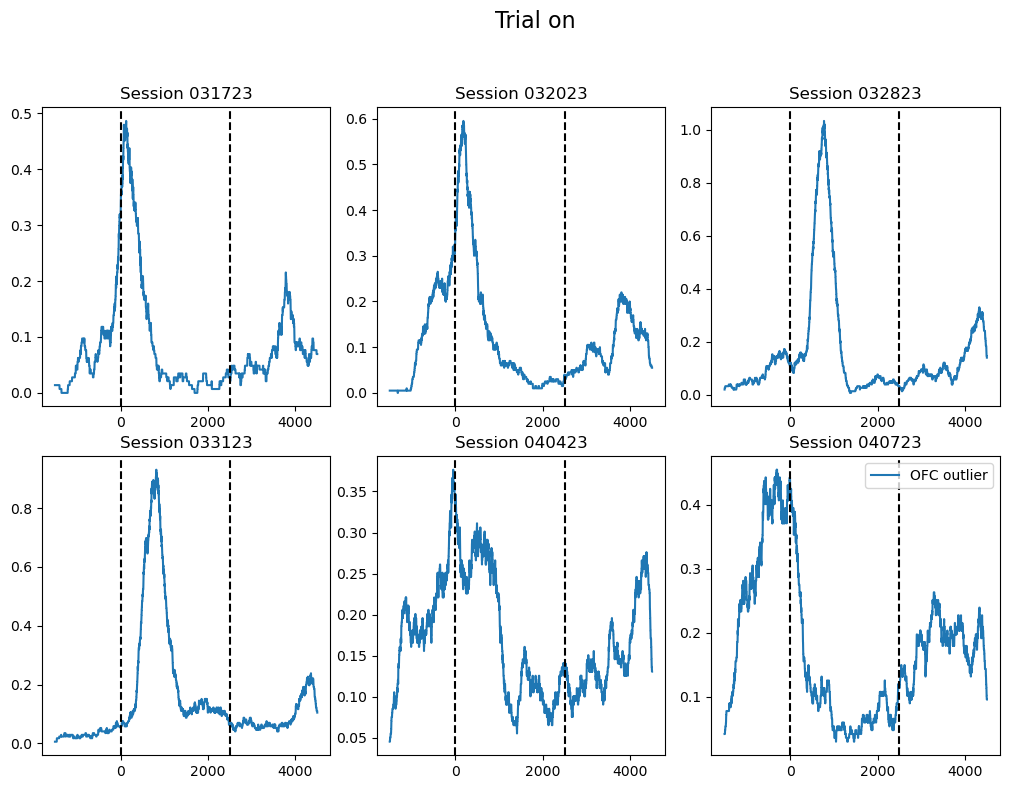

In [105]:
window = [-1500,4500]
timestamps = np.arange(window[0],window[1])

plt.close('all')
fig, axes = plt.subplots(2,3,figsize=(12,8))

for jj, date in enumerate(['031723','032023','032823','033123','040423','040723']):

    ripple_channel = identify_ripple(date)

    nwbfile = load_data.load_nwbfile('Bart',date) 
    trial_df = nwbfile.intervals['trials'].to_dataframe()
    trial_df = trial_df.loc[:,trial_df.columns[:-1]]
    
    row, col = np.divmod(jj,3)
    ax = axes[row,col]
    
    peaks = ripple_channel.query('hpc_channels>5').on.values
    _, ripple_rate_noOFC = get_ripple_raster(peaks,trial_df.query('trialerror<2'),window,istrial=1)
    ax.plot(timestamps,ripple_rate_noOFC,label='OFC outlier')
    
    # peaks = ripple_channel.query('(OFC_channels==0) & (HPC_channels>0)').on.values
    # ripple_rate_noOFC = get_ripple_raster(peaks,trial_df.query('trialerror==0'),window,istrial=0)
    # ax.plot(timestamps,ripple_rate_noOFC,label='Navigation',color='darkviolet')
    
    # peaks = ripple_channel.query('(OFC_channels>0) & (HPC_channels>0)').on.values
    # ripple_rate_OFC = get_ripple_raster(peaks,trial_df.query('trialerror<2'),window,istrial=0)
    # ax.plot(timestamps,ripple_rate_OFC,label='OFC detected')
    
    ax.set_title(f"Session {date}")
    ax.axvline(0,color='k',ls='--')
    ax.axvline(2500,color='k',ls='--')
    
    plt.legend()
    plt.tight_layout(h_pad=0.4,w_pad=0.4,rect=[0.05,0,0.9,0.95])
    plt.suptitle('Trial on',fontsize=16)
    # plt.savefig(f"D:/SWR/Ripple rate, OFC detected, reward on")

C:\Users\ML_4\AppData\Local\Temp\ipykernel_8304\901406156.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\ML_4\AppData\Local\Temp\ipykernel_8304\901406156.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\ML_4\AppData\Local\Temp\ipykernel_8304\901406156.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\ML_4\AppData\Local\Temp\ipykernel_8304\901406156.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


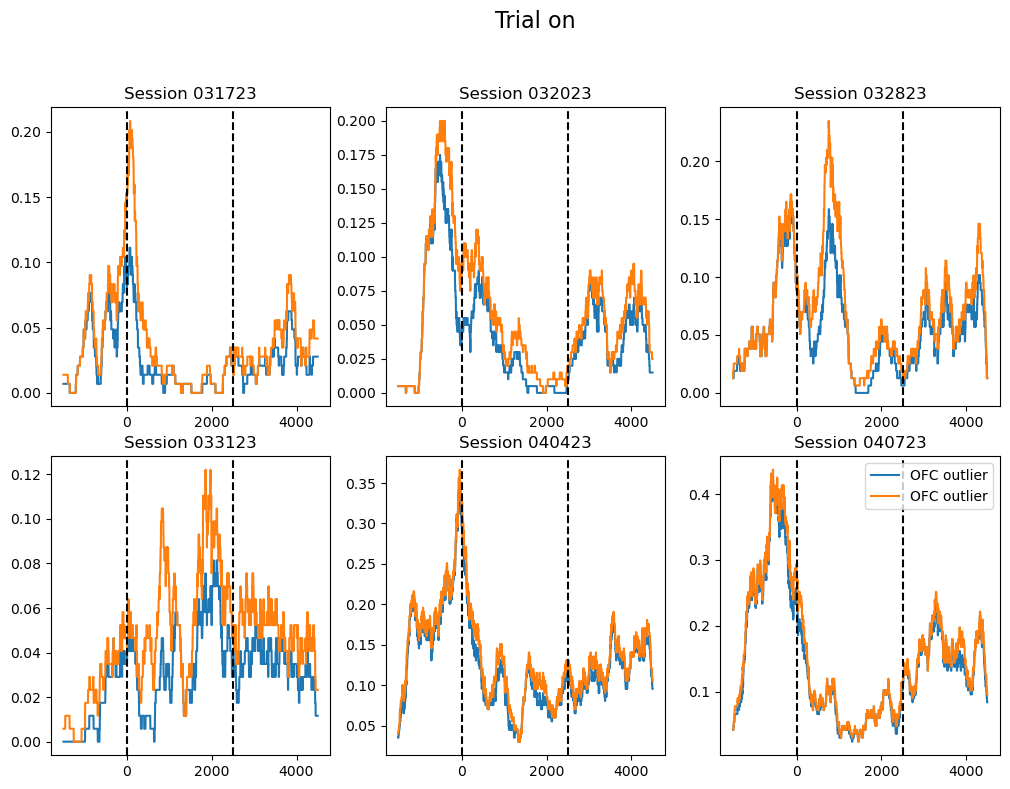

In [111]:
window = [-1500,4500]
timestamps = np.arange(window[0],window[1])

plt.close('all')
fig, axes = plt.subplots(2,3,figsize=(12,8))

for jj, date in enumerate(['031723','032023','032823','033123','040423','040723']):

    ripple_channel = identify_ripple(date)

    nwbfile = load_data.load_nwbfile('Bart',date) 
    trial_df = nwbfile.intervals['trials'].to_dataframe()
    trial_df = trial_df.loc[:,trial_df.columns[:-1]]
    
    row, col = np.divmod(jj,3)
    ax = axes[row,col]
    
    peaks = ripple_channel.query('(hpc_channels>5) & (ofc_channels==0)').on.values
    _, ripple_rate_noOFC = get_ripple_raster(peaks,trial_df.query('trialerror<2'),window,istrial=1)
    ax.plot(timestamps,ripple_rate_noOFC,label='OFC outlier')

    peaks = ripple_channel.query('(hpc_channels>5) & (ofc_channels<48)').on.values
    _, ripple_rate_noOFC = get_ripple_raster(peaks,trial_df.query('trialerror<2'),window,istrial=1)
    ax.plot(timestamps,ripple_rate_noOFC,label='OFC outlier')
    # peaks = ripple_channel.query('(OFC_channels==0) & (HPC_channels>0)').on.values
    # ripple_rate_noOFC = get_ripple_raster(peaks,trial_df.query('trialerror==0'),window,istrial=0)
    # ax.plot(timestamps,ripple_rate_noOFC,label='Navigation',color='darkviolet')
    
    # peaks = ripple_channel.query('(OFC_channels>0) & (HPC_channels>0)').on.values
    # ripple_rate_OFC = get_ripple_raster(peaks,trial_df.query('trialerror<2'),window,istrial=0)
    # ax.plot(timestamps,ripple_rate_OFC,label='OFC detected')
    
    ax.set_title(f"Session {date}")
    ax.axvline(0,color='k',ls='--')
    ax.axvline(2500,color='k',ls='--')
    
    plt.legend()
    plt.tight_layout(h_pad=0.4,w_pad=0.4,rect=[0.05,0,0.9,0.95])
    plt.suptitle('Trial on',fontsize=16)
    # plt.savefig(f"D:/SWR/Ripple rate, OFC detected, reward on")

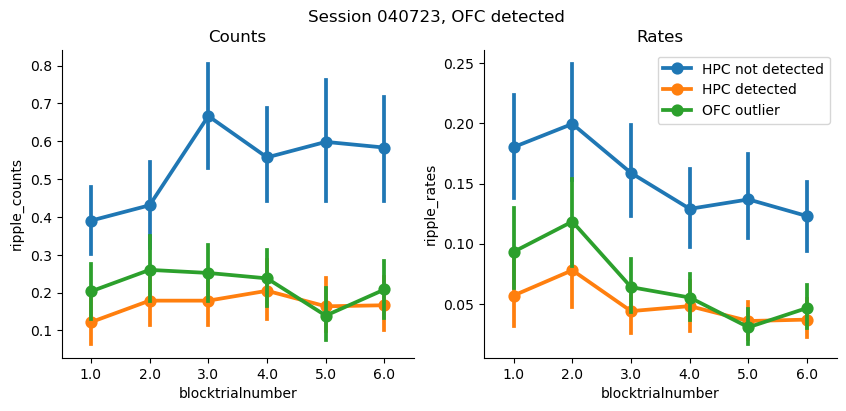

In [116]:
all_sessions_noHPC = pd.DataFrame()
all_sessions_HPC = pd.DataFrame()
all_sessions_outlier = pd.DataFrame()

for date in ['031723','032023','032823','033123','040423','040723']:
    
    ripple_channel = identify_ripple(date)
    
    window = [-1500,1500]
    timestamps = np.arange(window[0],window[1])
    
    nwbfile = load_data.load_nwbfile('Bart',date) 
    trial_df = nwbfile.intervals['trials'].to_dataframe()
    trial_df = trial_df.loc[:,trial_df.columns[:-1]]
    
    plt.close('all')
    fig, axes = plt.subplots(1,2,figsize=(10,4))
    
    peaks = ripple_channel.query('(ofc_channels>0) & (hpc_channels==0)').on.values
    counts, rates = get_trial_ripple_rate(peaks,trial_df)
    trial_df['ripple_counts']=counts
    trial_df['ripple_rates']=rates
    all_sessions_noHPC = pd.concat([all_sessions_noHPC,trial_df])
    
    sns.pointplot(data=trial_df.query('blocktrialnumber<7'), x='blocktrialnumber', y='ripple_counts',ax=axes[0])
    sns.pointplot(data=trial_df.query('blocktrialnumber<7'), x='blocktrialnumber', y='ripple_rates',label='HPC not detected',ax=axes[1])
    
    
    peaks = ripple_channel.query('(ofc_channels>0) & (hpc_channels>0)').on.values
    counts, rates = get_trial_ripple_rate(peaks,trial_df)
    trial_df['ripple_counts']=counts
    trial_df['ripple_rates']=rates
    all_sessions_HPC = pd.concat([all_sessions_HPC,trial_df])
    
    sns.pointplot(data=trial_df.query('blocktrialnumber<7'), x='blocktrialnumber', y='ripple_counts',ax=axes[0])
    sns.pointplot(data=trial_df.query('blocktrialnumber<7'), x='blocktrialnumber', y='ripple_rates',label='HPC detected',ax=axes[1])
    axes[0].set_title('Counts')
    axes[1].set_title('Rates')

    peaks = ripple_channel.query('ofc_outlier').on.values
    counts, rates = get_trial_ripple_rate(peaks,trial_df)
    trial_df['ripple_counts']=counts
    trial_df['ripple_rates']=rates
    all_sessions_outlier = pd.concat([all_sessions_outlier,trial_df])
    
    sns.pointplot(data=trial_df.query('blocktrialnumber<7'), x='blocktrialnumber', y='ripple_counts',ax=axes[0])
    sns.pointplot(data=trial_df.query('blocktrialnumber<7'), x='blocktrialnumber', y='ripple_rates',label='OFC outlier',ax=axes[1])
    axes[0].set_title('Counts')
    axes[1].set_title('Rates')
    
    # peaks = ripple_channel.query('(HPC_channels>0)').on.values
    # counts, rates = get_trial_ripple_rate(peaks,trial_df)
    # trial_df['ripple_counts']=counts
    # trial_df['ripple_rates']=rates
    # all_sessions = pd.concat([all_sessions,trial_df])
    
    sns.despine()
    plt.suptitle(f"Session {date}, OFC detected")
    plt.savefig(f"D:/SWR/Ripple rate, Session {date}, OFC detected")

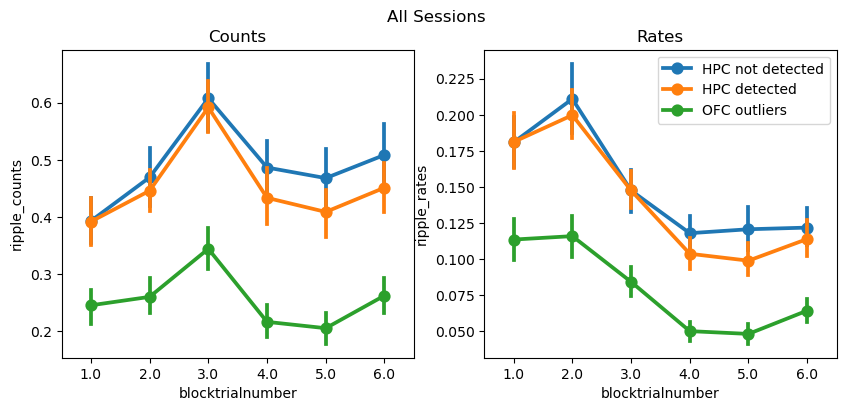

In [118]:
plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(10,4))

sns.pointplot(data=all_sessions_noHPC.query('blocktrialnumber<7'), x='blocktrialnumber', y='ripple_counts',label='',ax=axes[0])
sns.pointplot(data=all_sessions_noHPC.query('blocktrialnumber<7'), x='blocktrialnumber', y='ripple_rates',label='HPC not detected',ax=axes[1])

sns.pointplot(data=all_sessions_HPC.query('blocktrialnumber<7'), x='blocktrialnumber', y='ripple_counts',label='',ax=axes[0])
sns.pointplot(data=all_sessions_HPC.query('blocktrialnumber<7'), x='blocktrialnumber', y='ripple_rates',label='HPC detected',ax=axes[1])

sns.pointplot(data=all_sessions_outlier.query('blocktrialnumber<7'), x='blocktrialnumber', y='ripple_counts',label='',ax=axes[0])
sns.pointplot(data=all_sessions_outlier.query('blocktrialnumber<7'), x='blocktrialnumber', y='ripple_rates',label='OFC outliers',ax=axes[1])


axes[0].set_title('Counts')
axes[1].set_title('Rates')

plt.suptitle("All Sessions")
plt.savefig("D:/SWR/Ripple rate across trials, All Sessions, OFC outliers")

In [114]:
def get_trial_ripple_rate(peaks,df):
    
    starts = df.start_time.values
    stops = df.stop_time.values
    counts = np.zeros(len(df))
    rates = np.zeros(len(df))
    
    for tt in range(len(df)):
        rel_onset = (peaks>starts[tt]) & (peaks<stops[tt])
        if len(rel_onset)>0:
            counts[tt] = rel_onset.sum()
            rates[tt] = rel_onset.sum()/(stops[tt]-starts[tt])*1000
    
    return counts, rates

C:\Users\ML_4\AppData\Local\Temp\ipykernel_8304\2872368149.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\ML_4\AppData\Local\Temp\ipykernel_8304\2872368149.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\ML_4\AppData\Local\Temp\ipykernel_8304\2872368149.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\ML_4\AppData\Local\Temp\ipykernel_8304\2872368149.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legen

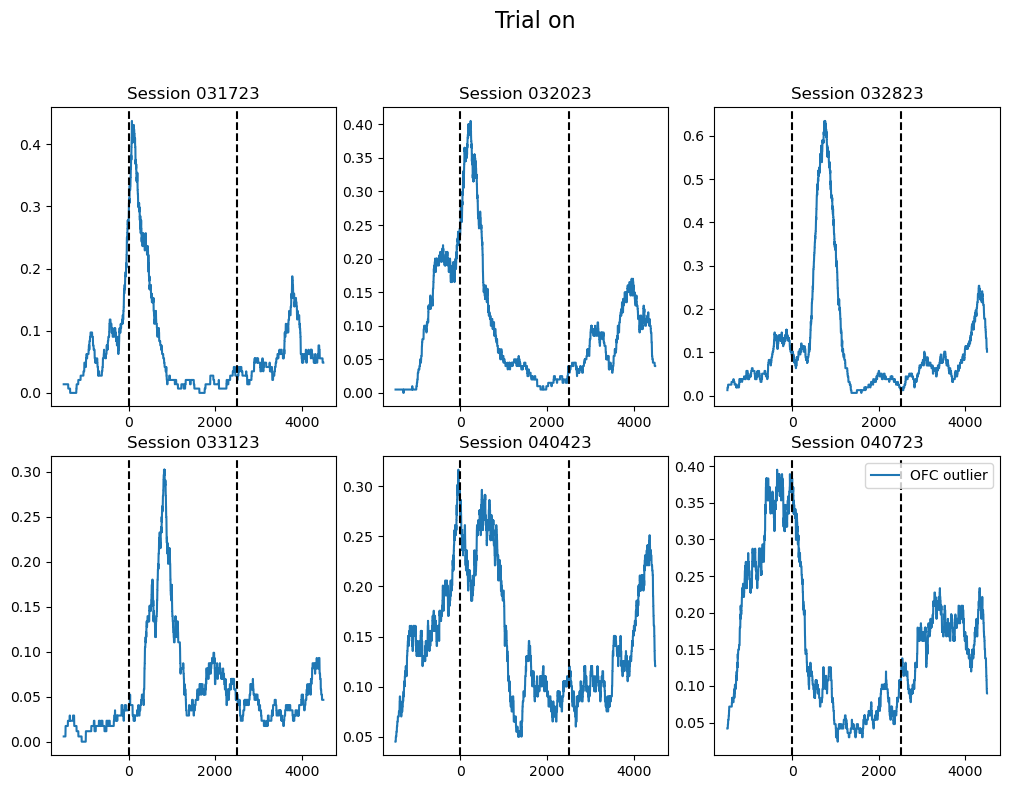

In [107]:
window = [-1500,4500]
timestamps = np.arange(window[0],window[1])

plt.close('all')
fig, axes = plt.subplots(2,3,figsize=(12,8))

for jj, date in enumerate(['031723','032023','032823','033123','040423','040723']):

    ripple_channel = identify_ripple(date)

    nwbfile = load_data.load_nwbfile('Bart',date) 
    trial_df = nwbfile.intervals['trials'].to_dataframe()
    trial_df = trial_df.loc[:,trial_df.columns[:-1]]
    
    row, col = np.divmod(jj,3)
    ax = axes[row,col]
    
    peaks = ripple_channel.query('(hpc_channels>5) & (hpc_channels<32)').on.values
    _, ripple_rate_noOFC = get_ripple_raster(peaks,trial_df.query('trialerror<2'),window,istrial=1)
    ax.plot(timestamps,ripple_rate_noOFC,label='OFC outlier')
    
    # peaks = ripple_channel.query('(OFC_channels==0) & (HPC_channels>0)').on.values
    # ripple_rate_noOFC = get_ripple_raster(peaks,trial_df.query('trialerror==0'),window,istrial=0)
    # ax.plot(timestamps,ripple_rate_noOFC,label='Navigation',color='darkviolet')
    
    # peaks = ripple_channel.query('(OFC_channels>0) & (HPC_channels>0)').on.values
    # ripple_rate_OFC = get_ripple_raster(peaks,trial_df.query('trialerror<2'),window,istrial=0)
    # ax.plot(timestamps,ripple_rate_OFC,label='OFC detected')
    
    ax.set_title(f"Session {date}")
    ax.axvline(0,color='k',ls='--')
    ax.axvline(2500,color='k',ls='--')
    
    plt.legend()
    plt.tight_layout(h_pad=0.4,w_pad=0.4,rect=[0.05,0,0.9,0.95])
    plt.suptitle('Trial on',fontsize=16)
    # plt.savefig(f"D:/SWR/Ripple rate, OFC detected, reward on")

In [88]:
def get_ripple_raster(peaks,df,window,istrial=0):
    
    ripple_time = np.zeros((len(df),window[1]-window[0]))
    if istrial:
        starts = df.start_time.values
    else:
        starts = df.t_on.values.astype(int)
    
    for tt in range(len(df)):
        rel_onset = (peaks[(peaks> starts[tt]+window[0]) & (peaks<starts[tt]+window[1])]-(starts[tt]+window[0])).astype(int)
    
        if len(rel_onset)>0:
            ripple_time[tt,rel_onset] = 1
    
    smoothed = 1000*np.convolve(ripple_time.mean(axis=0),np.ones(200)/200,mode='same')

    return ripple_time, smoothed

      rippleID       on      off  dur                    detected_channels  \
2719      2719  5715395  5715517  122  [32.0, 32.0, 32.0, 32.0, 32.0, 0.0]   

                        outlier_channels  ofc_outlier  hpc_outlier  
2719  [20.0, 21.0, 31.0, 18.0, 9.0, 0.0]         True         True  


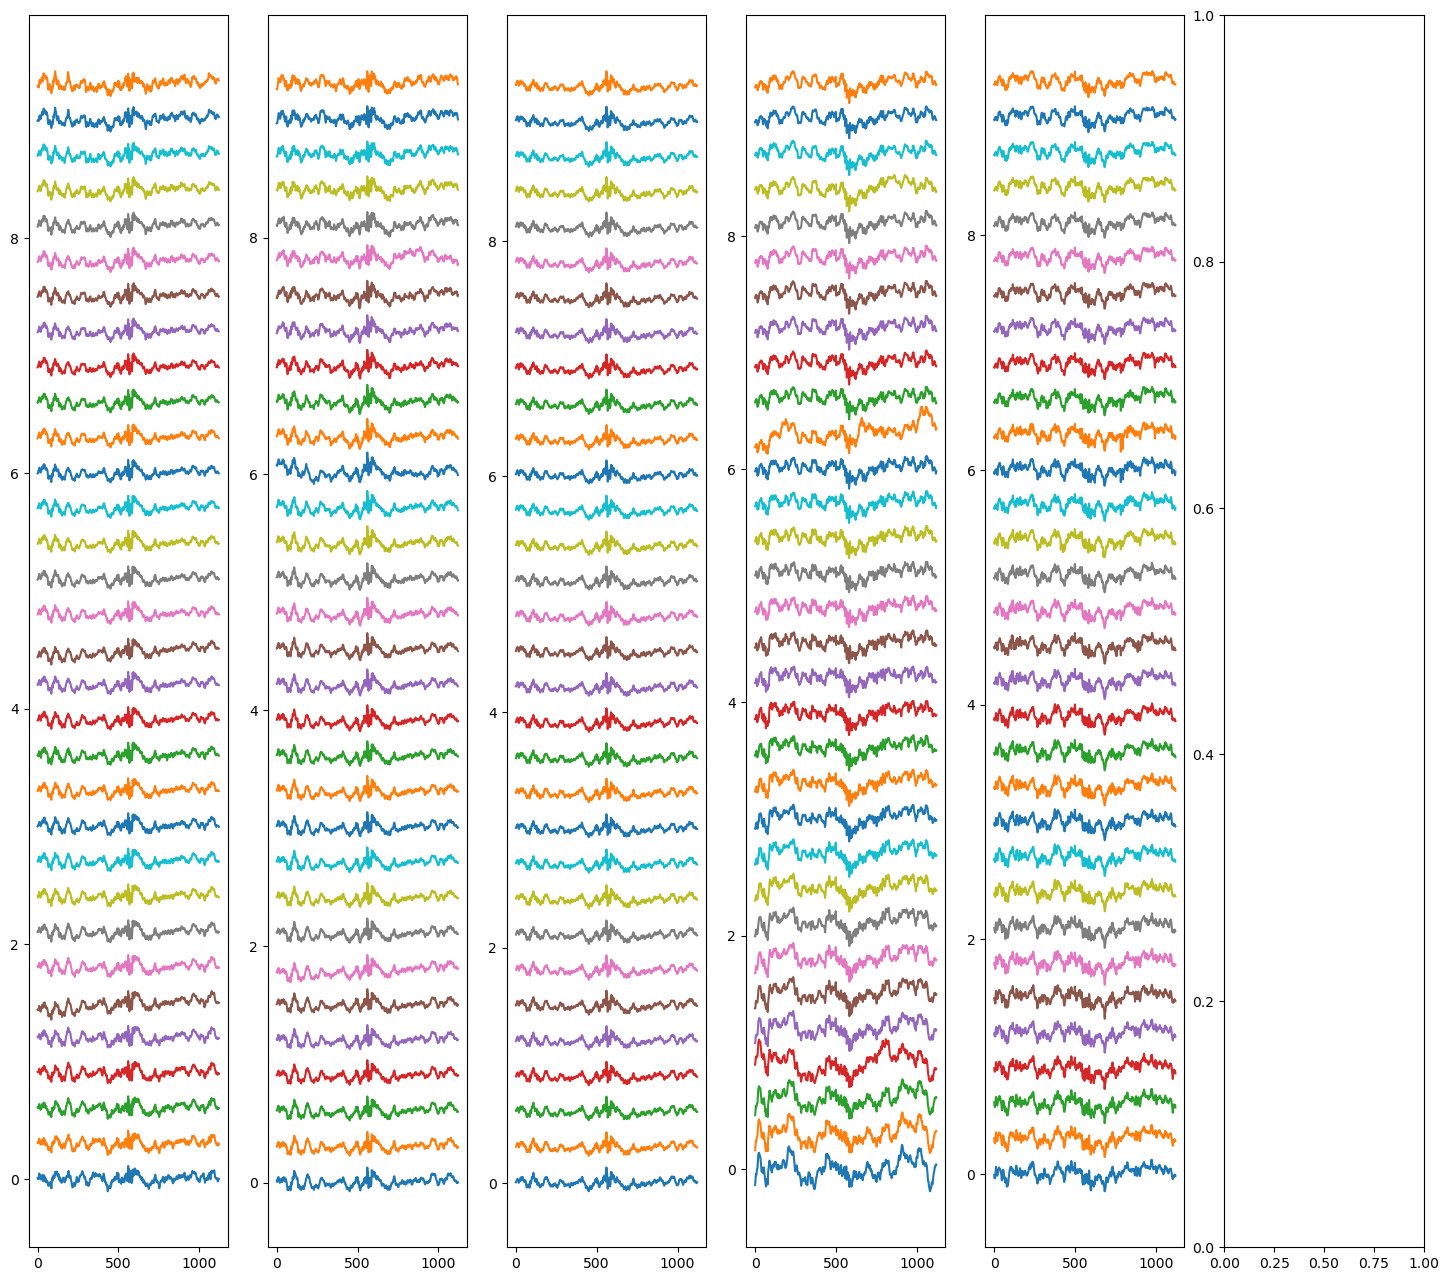

In [70]:
# visualize outliers
# idx = np.random.choice(len(outliers_ID))
idx = -1
outlier = ripple_channel.query('rippleID==@outliers_ID[@idx]')
print(outlier)
on = outlier.on.values[0]
off = outlier.off.values[0]

plt.close('all')
fig,axes = plt.subplots(1,6,figsize=(18,16))
for p in range(int(nchannels/32)):
    p_channels = np.arange(32*p,32*p+32)
    lfp_chunk = lfpData[on-500:off+500,:][:,p_channels]
    for ii in range(32):
        axes[p].plot(lfp_chunk[:,ii]+ii*0.3)

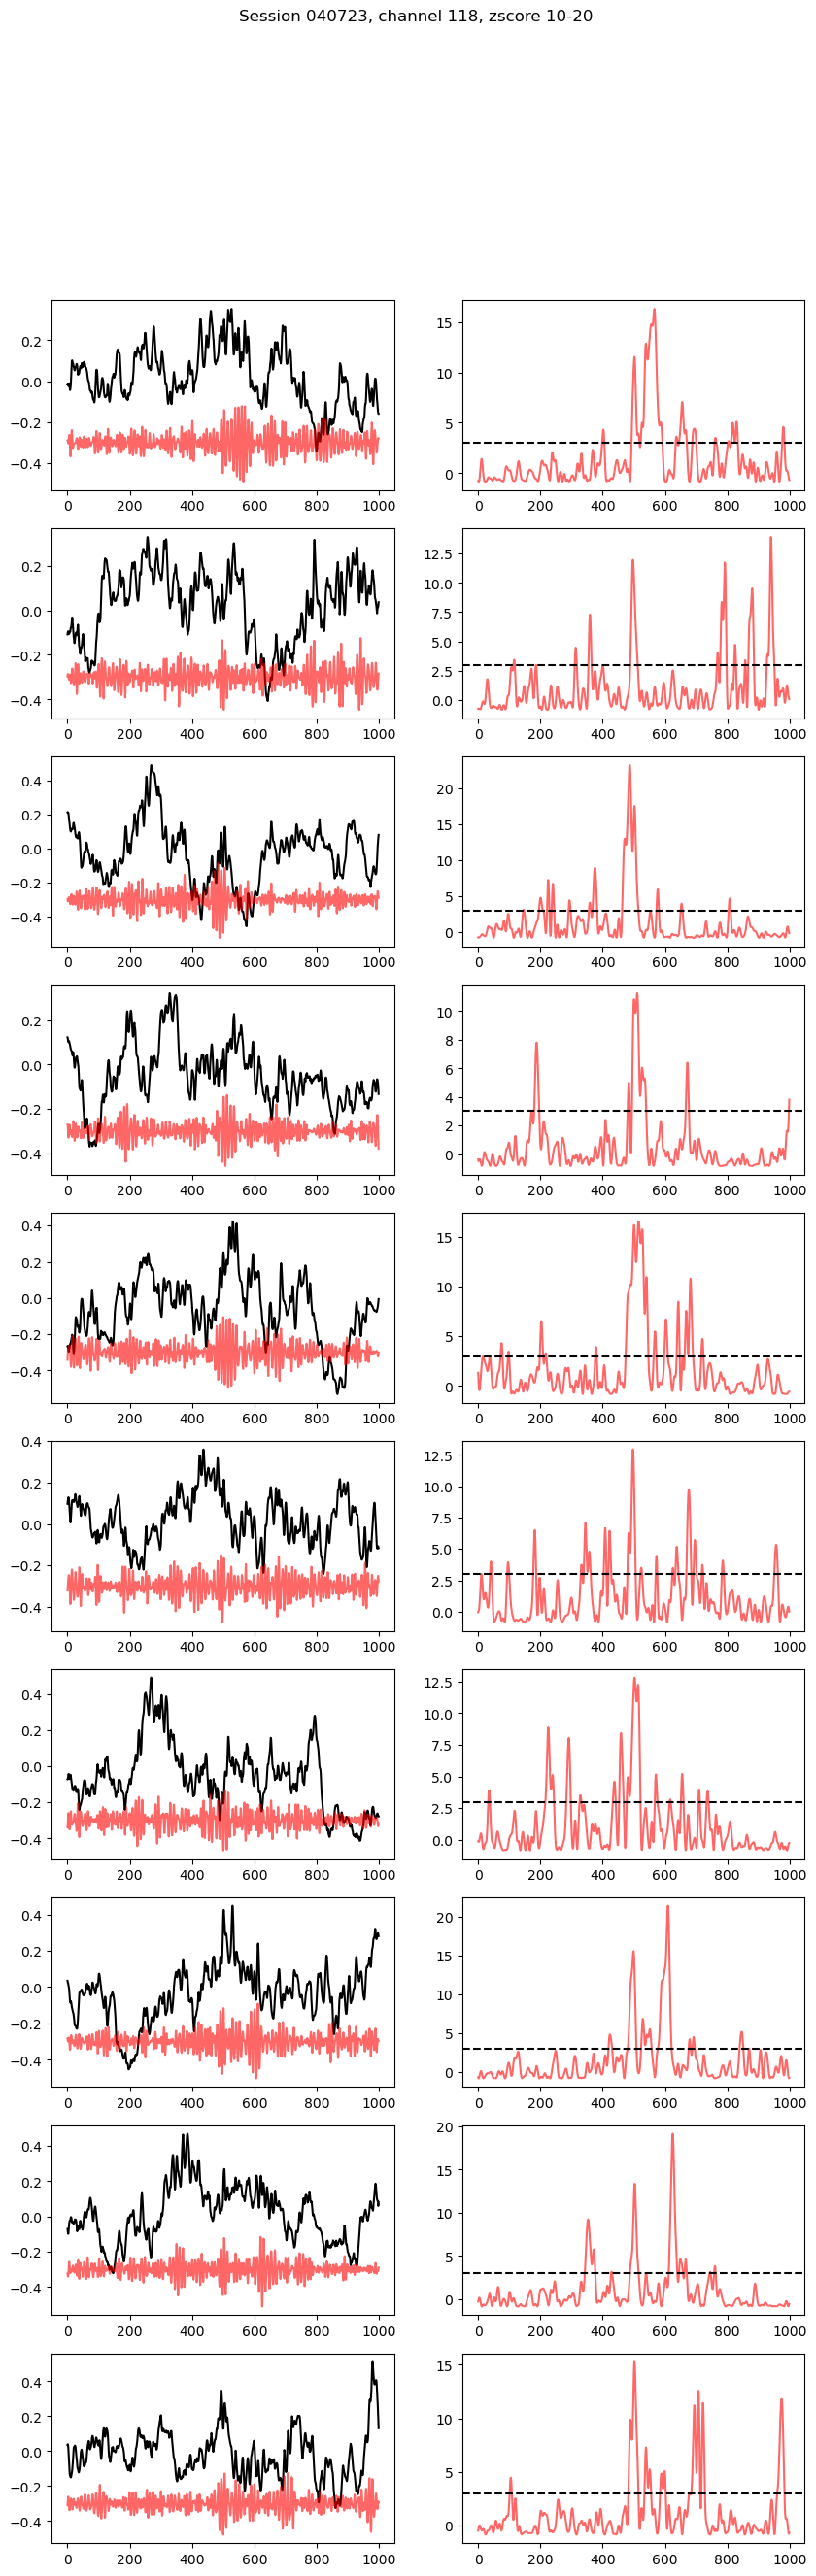

In [218]:
for date in ['031723','032023','032823','033123','040423','040723']:
    
    timestamps, lfpData = load_data.load_LFP(date)
    
    nwbfile = load_data.load_nwbfile('Bart',date)
    unitNames = nwbfile.units.to_dataframe()
    probes = unitNames.drop_duplicates('probe')
    
    ds = RippleDataset2("D:/SWR/Session_%s_RippleBand_80_180.h5" % date)
    power = ds.power_z[:]

    if date=='031723':
        power = power[:4000000,:]
    
    channel_yield = unitNames.groupby('channelNumbers').size().reset_index(name='count')
    high_yield_channels = channel_yield.query('(count>2)&(channelNumbers>96)').channelNumbers.values
    
    for ch in np.random.choice(high_yield_channels-1,size=10):
            
        ch_power = power[:,ch]
        zscore5_10 = np.where((ch_power>5) & (ch_power<10))[0]
        zscore10_20 = np.where((ch_power>10) & (ch_power<20))[0]
        random_ts = np.random.choice(zscore10_20,size=10)
        scale = 0.85
            
        plt.close('all')
        fig, axes = plt.subplots(10,2,figsize=(1000*0.005*2,30))
        
        for ii, time_idx in enumerate(random_ts):
                
            idx = np.arange(time_idx-500,time_idx+500)
            raw_LFP = lfpData[idx,:].astype(np.float32)
            
            ds = RippleDataset2("D:/SWR/Session_%s_RippleBand_80_180.h5" % date)
            band80_180 = ds.get_trace(idx)
            ds.close()
            
            axes[ii,0].plot(raw_LFP[:,ch],color='k')
            axes[ii,0].plot(band80_180['band_sig'][:, ch]*3-0.3,color='r',alpha=0.6)
            
            # axes[0].plot(band150_250['band_sig'][:, ch]*3+ch*scale-0.45,color='g',alpha=0.6)
            # axes[0].plot(band80_250['band_sig'][:, ch]*3+ch*scale-0.6,color='b',alpha=0.6)
            
            # scale = 3
            axes[ii,1].plot(band80_180['power_z'][:, ch],color='r',alpha=0.6)
            axes[ii,1].axhline(3,color='k',ls='--')
            # axes[1].plot(band150_250['power_z'][:, ch]+ch*scale-3,color='g',alpha=0.6)
            # axes[1].plot(band80_250['power_z'][:, ch]+ch*scale-6,color='b',alpha=0.6)
            
            # axes.text(20,ch*scale-0.25,f"CH {ch+1}",fontsize=18)
            plt.suptitle(f"Session {date}, channel {ch+1}, zscore 10-20")
            plt.savefig(f"D:/SWR/Session {date}, channel {ch+1}, zscore 10_20, high yield channel")

In [47]:
london_lfp = np.load('D:/London_OFC_HPC_data/London_TeleWorld_4x4_100324_g1/London_TeleWorld_4x4_100324_g1_imec1/sync_lfp.npy',mmap_mode='r')
london_ts = np.load('D:/London_OFC_HPC_data/London_TeleWorld_4x4_101124_g0/London_TeleWorld_4x4_101124_g0_imec1/sync_lfp_ts.npy',mmap_mode='r')
nwbfile = load_data.load_nwbfile('London','101124')
trial_df = nwbfile.intervals['trials'].to_dataframe()
unitNames = nwbfile.units.to_dataframe()

plt.close('all')
plt.figure(figsize=(20,385/5))
for ii in range(0,385,5):
    plt.plot(london_lfp[ii,600000:604000]+ii*20,color='k')

(1000, 160)

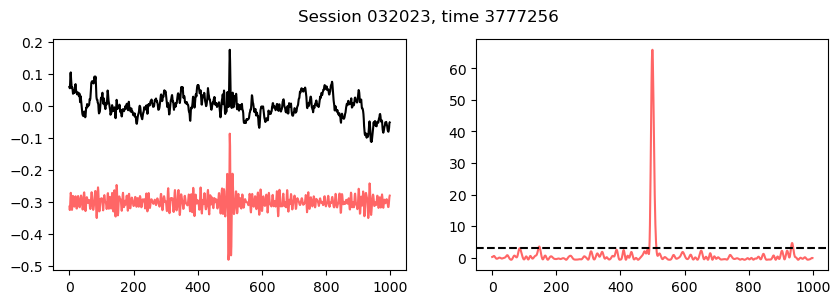

In [87]:
date = '032023'    
timestamps, lfpData = load_data.load_LFP(date)

nwbfile = load_data.load_nwbfile('Bart',date)
unitNames = nwbfile.units.to_dataframe()
probes = unitNames.drop_duplicates('probe')

ch = 0
scale = 0.85

plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(1000*0.005*2,3))

time_idx = 3777256
    
idx = np.arange(time_idx-500,time_idx+500)
raw_LFP = lfpData[idx,:].astype(np.float32)

ds = RippleDataset2("D:/SWR/Session_%s_RippleBand_80_180.h5" % date)
band80_180 = ds.get_trace(idx)
ds.close()

ch_power = band80_180['power_z'][:, ch]

axes[0].plot(raw_LFP[:,ch],color='k')
axes[0].plot(band80_180['band_sig'][:, ch]*3-0.3,color='r',alpha=0.6)

axes[1].plot(band80_180['power_z'][:, ch],color='r',alpha=0.6)
# axes[1].plot(smoothed,color='b',alpha=0.6)
axes[1].axhline(3,color='k',ls='--')
plt.suptitle(f"Session 032023, time {time_idx}")
plt.savefig('D:/SWR/noise_example')


In [76]:
from scipy.signal import windows, convolve


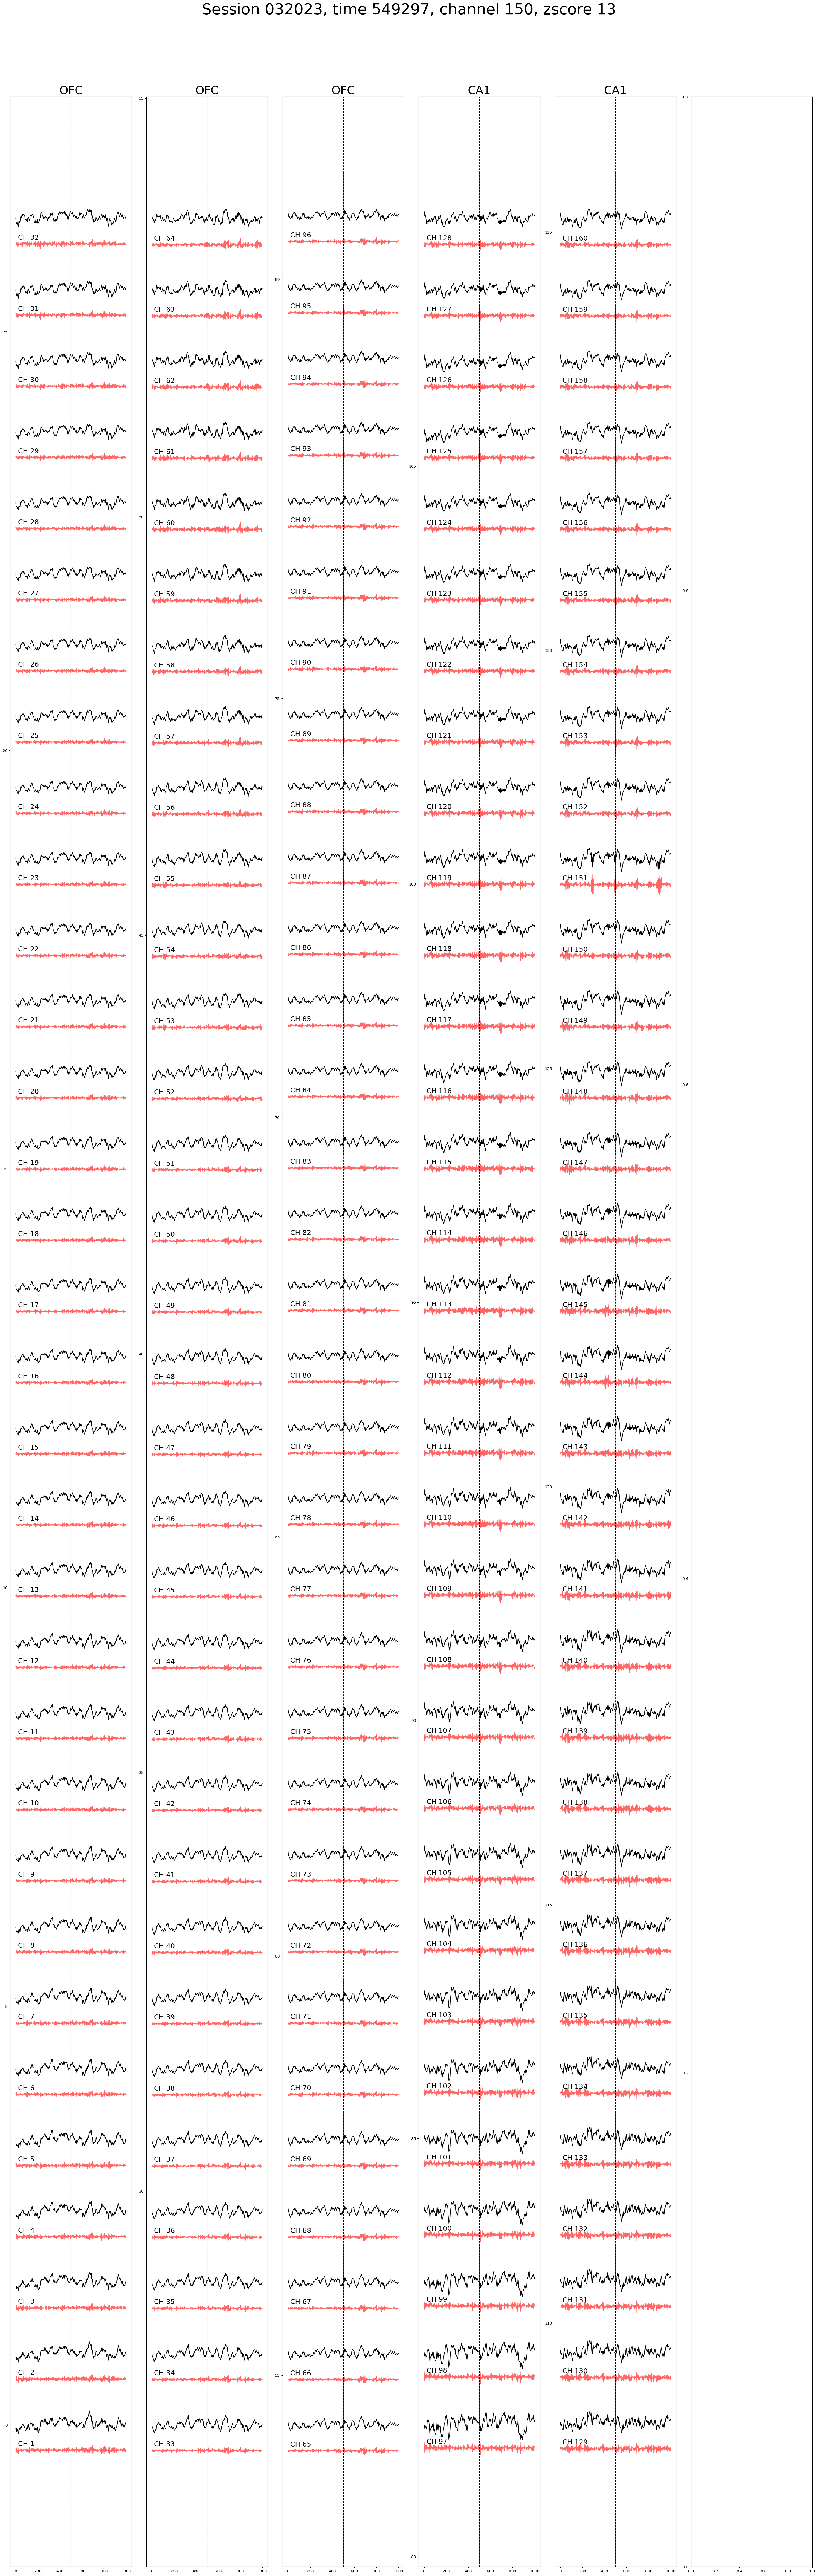

In [190]:
# for date in ['032823','033123','040423','040723']:

for time_idx in np.random.choice(zscore10_20,size=10):
    
    idx = np.arange(time_idx-500,time_idx+500)
    raw_LFP = lfpData[idx,:].astype(np.float32)
    
    ds = RippleDataset2("D:/SWR/Session_%s_RippleBand_80_180.h5" % date)
    band80_180 = ds.get_trace(idx)
    ds.close()
    
    scale = 0.85
    
    plt.close('all')
    fig, axes = plt.subplots(1,6,figsize=(1000*0.005*6,96))
    
    for ii, p in enumerate(probes.probe.unique()):
    
        sub_df = probes.query('probe==@p')
        region = sub_df.subfield.values[0]
        probe_channels = np.arange(sub_df.start_channel.min()-1, sub_df.end_channel.max())
        
        for ch in probe_channels:
            
            axes[ii].plot(raw_LFP[:,ch]+ch*scale,color='k')
            axes[ii].plot(band80_180['band_sig'][:, ch]*3+ch*scale-0.3,color='r',alpha=0.6)
            # peaks = SWR_peaks[ch][:,0]
            # ripple_idx = (peaks>(time_idx-500))&(peaks<(time_idx+500))
    
            # if np.sum(ripple_idx)>0:
            #     ripple_on = SWR_peaks[ch][ripple_idx,1][0]-time_idx+500
            #     ripple_off = SWR_peaks[ch][ripple_idx,2][0]-time_idx+500
            #     axes[ii].fill_between([ripple_on,ripple_off],ch*scale-0.5,ch*scale+0.25,color='b',alpha=0.1)
                
            # axes[ii].plot(band150_250['band_sig'][:, ch]*3+ch*scale-0.45,color='g',alpha=0.6)
            # axes[ii].plot(band80_250['band_sig'][:, ch]*3+ch*scale-0.6,color='b',alpha=0.6)
            axes[ii].text(20,ch*scale-0.25,f"CH {ch+1}",fontsize=18)
            axes[ii].set_title(region,fontsize=30)  
        
        # for ii in range(1,int(np.floor(trial_end/500))):
        #     axes.axvline(ii*500,color='gray')
        axes[ii].axvline(500,color='k',ls='--')
    plt.tight_layout(rect=[0,0,1,0.95])
        
    suptitle = 'Session %s, time %i, channel %i, zscore %i' % (date, time_idx, 150, ch_power[time_idx]) 
    plt.suptitle(suptitle,fontsize=40)
    plt.savefig('D:/SWR/Ripple'+suptitle)

In [1]:
from contextlib import contextmanager

@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()


In [4]:
dates = ['031723','032023','032823','033123','040423','040723']
band = [8,16]

for date in dates:
    
    timestamps, lfpData = load_data.load_LFP(date)
    lfpData = np.asarray(lfpData)
    n_channels = lfpData.shape[1]

    def process_channel(ch):
        sig = lfpData[:, ch]
        preprocessed = LFP.preprocess_LFP(sig)  
        band_sig, power, phase = LFP.freq_band(preprocessed, band)
        return  band_sig, power, phase # returns (band_sig, power, zscored, peaks)

    # Parallel over channels
    with tqdm_joblib(tqdm(total=n_channels)) as progress_bar:
        results = Parallel(n_jobs=-1)(delayed(process_channel)(ch) for ch in range(n_channels))

    # Unpack results into arrays
    band_sig = np.column_stack([r[0] for r in results])
    power = np.column_stack([r[1] for r in results])
    phase = np.column_stack([r[2] for r in results])

    # Save as HDF5
    outpath = f"D:/Alpha/Session_{date}_{band[0]}_{band[1]}.h5"

    with h5py.File(outpath, "w") as h5:
        h5.create_dataset("band_sig", data=band_sig, dtype='float32')
        h5.create_dataset("power", data=power, dtype='float32')
        h5.create_dataset("phase", data=phase, dtype='float32')
        h5.create_dataset("timestamps", data=timestamps, dtype='float32')

    print(f"Saved {outpath}")


%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

C:\Users\ML_4\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Saved D:/Alpha/Session_031723_8_16.h5




         | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Saved D:/Alpha/Session_032023_8_16.h5





      | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

Saved D:/Alpha/Session_032823_8_16.h5






   | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [11:00<?, ?it/s]


Saved D:/Alpha/Session_033123_8_16.h5




         | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

Saved D:/Alpha/Session_040423_8_16.h5





      | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

Saved D:/Alpha/Session_040723_8_16.h5


In [2]:
dates = ['031723','032023','032823','033123','040423','040723']
bands = [[80,180],[150,250],[80,250]]

for band in bands:
    for date in dates:
        
        path = f"D:/SWR/Session_{date}_RippleBand_{band[0]}_{band[1]}.h5"
        
        with h5py.File(path, "r+") as h5:
            power = h5["power"][:]
        
            mean = power.mean(axis=0, keepdims=True)
            std = power.std(axis=0, keepdims=True)
            power_z = (power - mean) / std
        
            h5.create_dataset("power_z", data=power_z, dtype="float32")
